#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
print(y_train)
y_train[0]

[1 0 0 ... 0 1 0]


1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

---
In the choice of, **Activation for Output Layer**, we take into account that we want an output of 1 and 0s, so we use sigmoid to give us these outputs w.r.t inputs of the unit.

Target labels used to train a model with a sigmoid activation function in the output layer will have the values 0 or 1


---
In the choice of, **Binary Classification Loss Function**, as mentioned our target labels are specific 0 and 1. 
Mathematically, binary cross-entropy is the preferred loss function under the inference framework of maximum likelihood. It is the loss function to be evaluated first and only changed if you have a good reason.

Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. The score is minimized and a perfect cross-entropy value is 0.


---
Also, by trying out different activation functions for the hidden rnn I decided on the ReLu activation due to higher validation accuracy.

---


refrences:

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 100s 504ms/step - loss: 0.6766 - accuracy: 0.5711 - val_loss: 0.5792 - val_accuracy: 0.7188
Epoch 2/10
196/196 [==============================] - 98s 501ms/step - loss: 0.6242 - accuracy: 0.6944 - val_loss: 0.4952 - val_accuracy: 0.7946
Epoch 3/10
196/196 [==============================] - 98s 499ms/step - loss: 0.4496 - accuracy: 0.8075 - val_loss: 0.4105 - val_accuracy: 0.8278
Epoch 4/10
196/196 [==============================] - 97s 494ms/step - loss: 0.3230 - accuracy: 0.8711 - val_loss: 0.3690 - val_accuracy: 0.8450
Epoch 5/10
196/196 [==============================] - 97s 493ms/step - loss: 0.2869 - accuracy: 0.8871 - val_loss: 0.3813 - val_accuracy: 0.8385
Epoch 6/10
196/196 [==============================] - 97s 493ms/step - loss: 0.3399 - accuracy: 0.8648 - val_loss: 0.3918 - val_accuracy: 0.8252
Epoch 7/10
196/196 [==============================] - 97s 496ms/step - loss: 0.2543 - accuracy: 0.9047 - val_loss: 0.3735 - val_a

Print the values of accuracy and the loss , and evaluate the model on the 

---

test set

391/391 - 13s - loss: 0.3798 - accuracy: 0.8551
accuracy: 85.51%


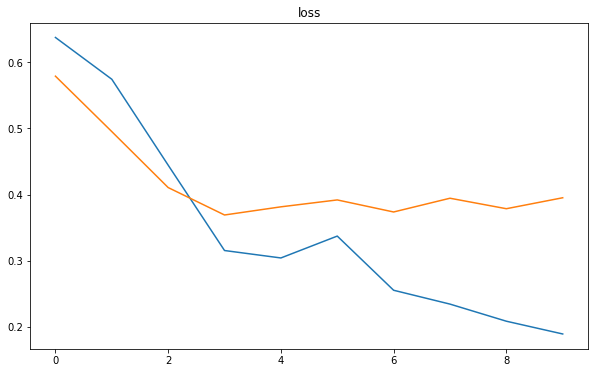

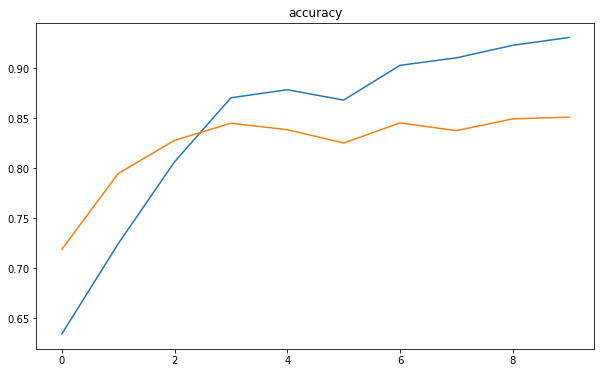

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*



---



---


To have a fair comparison, I have defined the models with more or less the same number of parameters.

In general, if the dataset is small then GRU is preferred otherwise LSTM for the larger dataset. 
In terms of model training speed, GRU is 29.29% faster than LSTM for processing the same dataset because GRU has 2 gates instead of 3 in LSTM.
Also, in terms of performance, GRU performance will surpass LSTM in the scenario of long text and small dataset, and inferior to LSTM in other scenarios.


---
In this scenario, the **performance** of both models is similar, with slightly better accuracy in LSTM.

The **number of parameters** is very close to each other, 105 and 104 thousand, in LSTM and GRU models respectively, which is a little more than the simpleRNN model.

The **number of units** across models is 32.
Although I mentioned that GRU, in general, is faster, here we can see that **training time** does not differ between the two models, and even GRU has spent more time in training.


---
Reference:
https://www.dezyre.com/recipes/what-is-difference-between-gru-and-lstm-explain-with-example#:~:text=The%20key%20difference%20between%20GRU,are%20input%2C%20output%2C%20forget.&text=If%20the%20dataset%20is%20small,layers%20but%20LSTM%20doesn't.


In [ ]:
################### LSTM
modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
modelLSTM.add(keras.layers.LSTM(32))
modelLSTM.add(keras.layers.Dense(1, activation='sigmoid'))
modelLSTM.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
modelLSTM.summary()
historyLSTM = modelLSTM.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 105,537
Trainable params: 105,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 20s 90ms/step - loss: 0.6595 - accuracy: 0.5807 - val_loss: 0.3892 - val_accuracy: 0.8362
Epoch 2/10
196/196 [==============================] - 17s 88ms/step - loss: 0.3202 - accuracy: 0.8694 - val_loss: 0.3435 - val_accuracy: 0.8540
Epoch 3/10
196/196 [==============================] - 17s 88ms/step - loss: 0.2387 - accur

391/391 - 11s - loss: 0.5279 - accuracy: 0.8574
accuracy: 85.74%


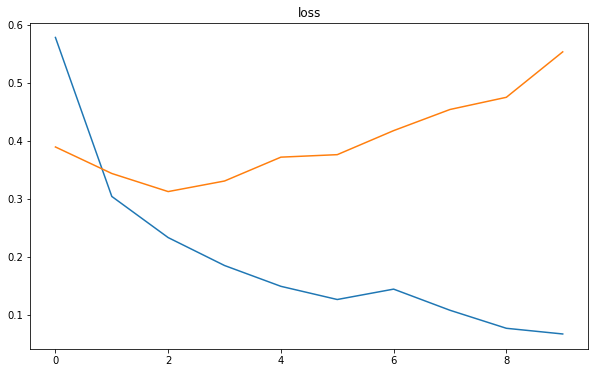

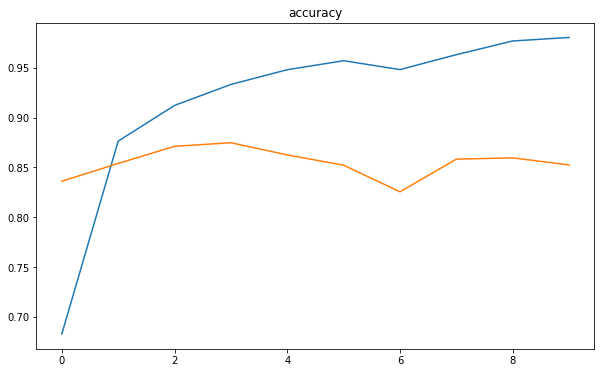

In [ ]:
plot_loss(historyLSTM )
plot_accuracy(historyLSTM )
scores = modelLSTM.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (modelLSTM.metrics_names[1], scores[1]*100))

In [ ]:
################### GRU
modelGRU = keras.models.Sequential()
modelGRU.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
modelGRU.add(keras.layers.GRU(32))
modelGRU.add(keras.layers.Dense(1, activation='sigmoid'))
modelGRU.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
modelGRU.summary()
historyGRU = modelGRU.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 21s 99ms/step - loss: 0.6473 - accuracy: 0.6067 - val_loss: 0.4050 - val_accuracy: 0.8190
Epoch 2/10
196/196 [==============================] - 19s 96ms/step - loss: 0.2795 - accuracy: 0.8857 - val_loss: 0.3338 - val_accuracy: 0.8584
Epoch 3/10
196/196 [==============================] - 19s 96ms/step - loss: 0.1956 - accur

391/391 - 11s - loss: 0.5664 - accuracy: 0.8462
accuracy: 84.62%


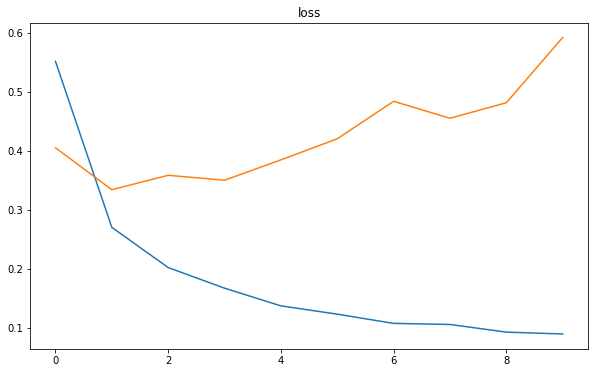

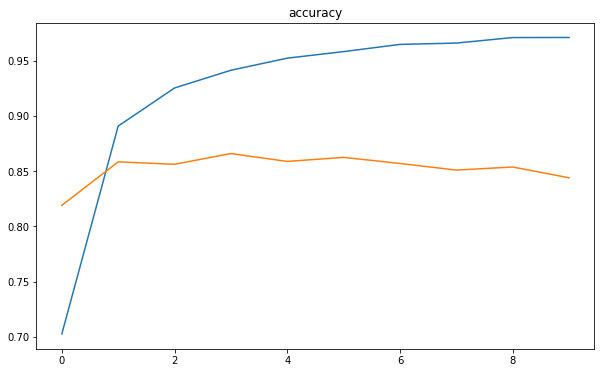

In [ ]:
plot_loss(historyGRU)
plot_accuracy(historyGRU)
scores = modelGRU.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (modelGRU.metrics_names[1], scores[1]*100))

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 44s 204ms/step - loss: 0.6592 - accuracy: 0.6002 - val_loss: 0.4536 - val_accuracy: 0.8338
Epoch 2/5
196/196 [==============================] - 39s 200ms/step - loss: 0.4298 - accuracy: 0.8206 - val_loss: 0.3215 - val_accuracy: 0.8650
Epoch 3/5
196/196 [==============================] - 39s 199ms/step - loss: 0.2675 - accur

391/391 - 23s - loss: 0.3163 - accuracy: 0.8724
accuracy: 87.24%


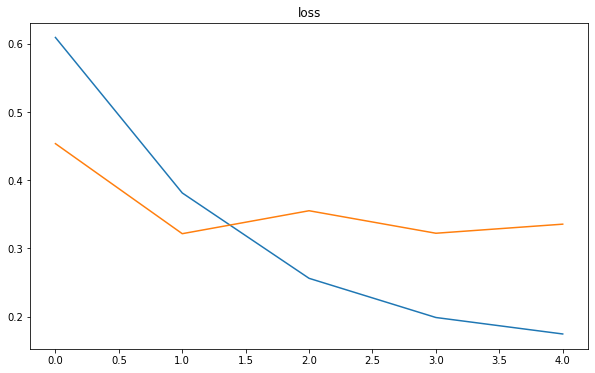

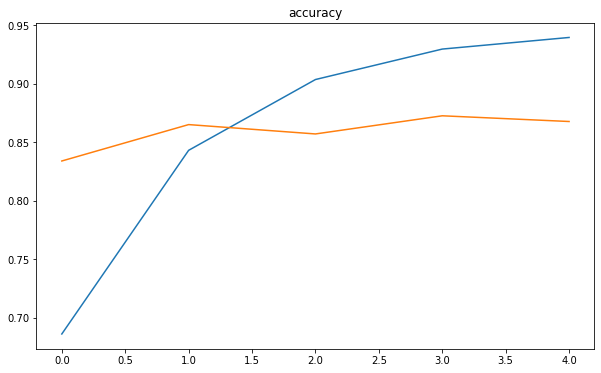

In [ ]:
plot_loss(history)
plot_accuracy(history)
scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

By adding the dropout after the LSTM layer, we see that the overfitting issue is not solved, so I tried adding the dropout before the LSTM layer. 
Which had better results with 0.7 probability dropout, and we have better validation accuracy than any other model. 
Overfitting is also lower, and with a 0.8 dropout probability, we do not have any overfitting, the trade-off is the validation accuracy which gets lower too.

---

To modify the values of some other hyper-parameters to mitigate overfitting, we can run a for loop on the number of units and the learning rate of our optimizer.
By changing the number of units, we see that we still have overfitting.
When we change the learning rate, we require more epochs, which needs more time to train, and if we want it to reach this validation accuracy, we still come across the overfitting problem at the end is not the better choice in this scenario.

Other ways of dealing with this problem are regularization, early stopping and batch-size . 

In early stopping, we have a better chance to stop the unnecessary waste of time due to stopping the training when we have no improvement over a specified metric(val_loss).

As for regularization, we have the chance to find a trade-off between losing accuracy and overfitting. Here, this is tested by an exhaustive grid search over all possible outcomes. 

For batch size we see that higher numbers reduce the variance and make the overfitting problem less but still with lower validation accuracy w.r.t dropout.

In conclusion, considering all of the methods, above we see that dropout is the most suited in this case.


In [ ]:
model_bidirectionalD = keras.models.Sequential()
model_bidirectionalD.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))

model_bidirectionalD.add(keras.layers.Dropout(0.7))

model_bidirectionalD.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))

model_bidirectionalD.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectionalD.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectionalD.summary()

historyD = model_bidirectionalD.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 43s 204ms/step - loss: 0.6532 - accuracy: 0.5872 - val_loss: 0.3872 - val_accuracy: 0.8427
Epoch 2/5
196/196 [==============================] - 39s 200ms/step - loss: 0.3595 - accuracy: 0.8503

391/391 - 23s - loss: 0.2714 - accuracy: 0.8906
accuracy: 89.06%


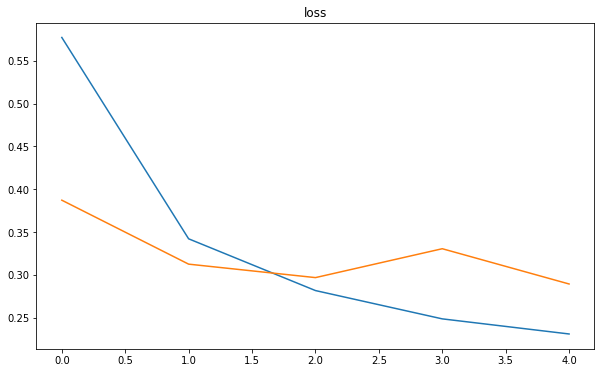

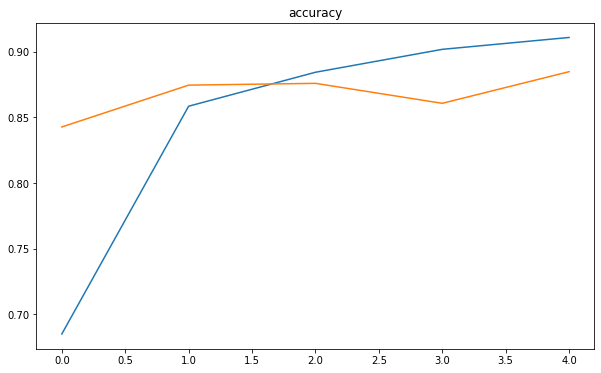

In [ ]:
plot_loss(historyD)
plot_accuracy(historyD)

scores = model_bidirectionalD.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectionalD.metrics_names[1], scores[1]*100))